# SVM Simulation with Gaussian Data

In [19]:
# Set-Up
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

from sklearn.datasets.samples_generator import make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import cvxopt
import pickle

In [2]:
# Gaussian data
X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

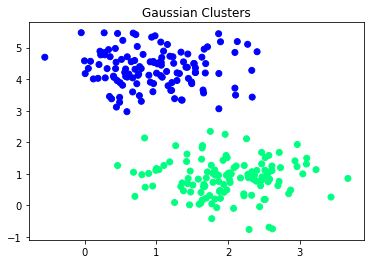

In [3]:
# Plot clusters
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')
plt.title("Gaussian Clusters")
plt.savefig('Figures/gaussian_samples.png')

In [4]:
# implement sklearn svm
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = LinearSVC()
svc.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

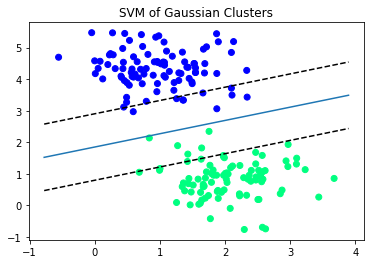

In [5]:
# Plot simulation SVM
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='winter');
ax = plt.gca()
plt.title("SVM of Gaussian Clusters")
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')
plt.savefig('Figures/gaussian_svm.png')

# Model Fitting and Prediction

In [6]:
# import packages for nlp analyses
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

!curl -s -O http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b

import re 
pronunciations = dict()
file = 'cmudict-0.7b'
for line in open(file,encoding = 'latin-1').readlines():
    line = line.strip()
    if line.startswith(';'): continue
    word,phones = line.split("  ")
    word = word.rstrip("(0123)").lower()
    if word not in pronunciations:
        pronunciations[word] = []
    pronunciations[word].append(phones)
    
stopwords = nltk.corpus.stopwords.words("english")
no_punct = lambda x: re.sub(r'[^\w\s]', '', x)
import json

np.random.seed(403)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imehr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\imehr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imehr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\imehr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
# load datasets
nycc = pd.read_csv("Data/nycc_captions.csv")
nycc = nycc.loc[:'text'].values

abc_news = pd.read_csv("Data/abcnews-date-text.csv")
abc_news = abc_news.loc[:'text'].values

oneliners = pd.read_csv("Data/oneliners-text.csv")
oneliners = oneliners.loc[:'text'].values

proverbs = pd.read_csv("Data/proverbs.csv")
proverbs = proverbs.loc[:'text'].values

nycc_context = pd.read_csv("Data/context_captions.csv")
nycc_context = nycc_context.loc[:'text'].values

context = pd.read_csv("Data/nycc_context.csv")
context = context.loc[:'context'].values

In [8]:
def len_match(humor, non_humor):
    # create data sets of equal sizes
    # input is two data sets, output is two data sets of equal length
    if len(humor) > len(non_humor):
        humor = humor[random.sample(range(0, len(humor)), len(non_humor))]
    else:
        non_humor = non_humor[random.sample(range(0, len(non_humor)), len(humor))]
    return humor, non_humor

# Syntactic Features

In [9]:
## ALLITERATION
def removeNonWords(phrase):
    # removes non-letter characters from string input
    bad_chars = [';', ':', '!', '*', ',', '.', '-', '"', '?', '1','2','3','4','5','6','7','8','9','0']
    for bad in bad_chars:
        if (bad in phrase):
            phrase = phrase.replace(bad, '')
    line = phrase.split()
    return line

def alliterations(phrase):
    # returns the number of alliterations in a given phrase
    
    # remove non-letter characters
    phones_dict = {}
    phrase = removeNonWords(phrase)
    for word in phrase:
        word = word.lower()
        try:
            if (word not in stopwords or word in pronunciations):
                phones_lst = pronunciations[word][0].split()
                phones_dict[word] = phones_lst
        except:
            continue
            
    # count occurences of alliteration
    count = 0
    key_lst = list(phones_dict.keys())
    for cur in range(0, len(phones_dict)):
        if (cur + 1 < len(phones_dict)):
            for next_index in range(cur+1, len(phones_dict)):
                if (phones_dict[key_lst[cur]][0] == phones_dict[key_lst[next_index]][0]):
                    count += 1
    return count

def alliteration_dict(data):
    # create dictionary with number of alliterations per phrase
    a_dict = {}
    for i in range(len(data)):
        a_dict[i] = alliterations(data[i][0])
    return a_dict

In [10]:
## ANTONOMY
def find_ant(word):
    # find antonyms of a given word
    ant = list()
    for synset in wordnet.synsets(word):
        for lemma in synset.lemmas():
            if lemma.antonyms():
                ant.append(lemma.antonyms()[0].name())
    return set(ant)
    
def num_ant(phrase):
    # find number of antonyms in a phrase
    ant_dict = {}
    count = 0
    phrase = removeNonWords(phrase)
    
    for word in phrase:
        antonyms = find_ant(word)
        for antonym in antonyms:
            if antonym in phrase:
                count += 1
    return count

def antonym_dict(data):
    # create dictionary with number of antonyms per phrase
    ant_dict = {}
    for i in range (len(data)):
        ant_dict[i] = num_ant(data[i][0])
    return(ant_dict)


In [11]:
## SYNONYMY
def find_syn(word):
    # find synonyms of a given word
    syn = []
    for synset in wordnet.synsets(word):
        for lemma in synset.lemmas():
            syn.append(lemma.name())
    return set(syn)

def num_syn(phrase, context):
    # find number of synonyms between two phrases
    synonyms = []
    for word in context:
        synonyms.append(list(find_syn(word)))
        
    flat_syn = []
    for sublist in synonyms:
        for item in sublist:
            flat_syn.append(item)
    flat_syn = set(flat_syn)
    
        
    count = 0
    phrase = removeNonWords(phrase)
    
    for word in phrase:
        if word in flat_syn:
            count += 1
    return count

def synonym_dict(data, context):
    # create dictionary with number of antonyms per phrase
    syn_dict = {}
    for i in range(len(data)):
        syn_dict[i] = num_syn(data[i][0], context)
    return syn_dict

# Decision Tree

In [12]:
## DECISION TREE
def decisionTree (phrase):
    # rules for decision tree
    # a phrase is humorous if it contains alliteration and/or antonomy
    if (alliterations(phrase) == 0):
        if (num_ant(phrase) <= 1): # antonymy should occur in pairs
            return False
        else:
            return True
    elif (alliterations(phrase) > 0):
        return True
    else:
        return False
    
def tree_accuracy(data):
    # decision tree accuracy
    heuristic = {}
    correct_sum = 0
    for i in range(len(data)):
        result = decisionTree(data[i][0])
        if (result == True):
            correct_sum +=1
        heuristic[i] = result
    return(correct_sum/len(data))

def tree_model(humor, nonhumor):
    # runs full decision tree model
    # output is the proportion of correct classification 
    
    # match data length
    humor, nonhumor = len_match(humor, nonhumor)
    
    # find decision tree accuracy
    humor_acc = tree_accuracy(humor)
    nonhumor_acc = tree_accuracy(nonhumor)
    return np.mean([humor_acc, nonhumor_acc])


In [13]:
# run decision tree on humor/nonhumor data set pairings
np.random.seed(403)
tree_model_acc = [tree_model(oneliners, abc_news), tree_model(oneliners, proverbs),
                  tree_model(nycc, abc_news), tree_model(nycc, proverbs)]

# Syntax SVM Model

In [14]:
## SYNTAX SVM MODEL

# ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

In [15]:
def df_arrange(humor, nonhumor):
    # outputs data frame with counts of alliteration and antonymy, used in the syntax SVM model
    
    # create dictionaries with alliteration per phrase
    humor_all_dict = alliteration_dict(humor)
    nonhumor_all_dict = alliteration_dict(nonhumor)
    # create dictionaries with antonyms per phrase
    humor_ant_dict = antonym_dict(humor)
    nonhumor_ant_dict = antonym_dict(nonhumor)
    
    # create list of labels
    label = []
    for i in range(len(humor)):
        label.append("humor")
    for i in range(len(nonhumor)):
        label.append("nonhumor")
    
    # create list of alliteration values
    alit_lst = []
    for i in range(len(humor)):
        alit_lst.append(list(humor_all_dict.values())[i])
    for i in range(len(nonhumor)):
        alit_lst.append(list(nonhumor_all_dict.values())[i])
    
    #create list of antonym values
    ant_lst = []
    for i in range(len(humor)):
        ant_lst.append(list(humor_ant_dict.values())[i])
    for i in range(len(nonhumor)):
        ant_lst.append(list(nonhumor_ant_dict.values())[i])
    
    # create data frame
    column_names = ["alliteration", "antonymy", "label"]
    df = pd.DataFrame(columns = column_names)
    df['alliteration'] = alit_lst
    df['antonymy'] = ant_lst
    df['label'] = label
    
    return df


def syntax_svm(df):
    # body of syntax SVM model
    
    training_set, test_set = train_test_split(df, test_size = 0.2, random_state = 1)
    x_train = training_set.iloc[:,0:2].values
    y_train = training_set.iloc[:,2].values
    x_test = test_set.iloc[:,0:2].values
    y_test = test_set.iloc[:,2].values
    
    classifier = SVC(kernel='linear', random_state = 1, gamma= 'auto')
    classifier.fit(x_train,y_train)
    y_pred = list(classifier.predict(x_test))
    test_set["Predictions"] = y_pred
    
    cm = confusion_matrix(y_test,y_pred)
    accuracy = float(cm.diagonal().sum())/len(y_test)
    
    return accuracy


def syntax_svm_model(humor, nonhumor):
    # run full syntax model
    
    # match data length
    humor, nonhumor = len_match(humor, nonhumor)
    
    df = df_arrange(humor, nonhumor)
    accuracy = syntax_svm(df)
    
    return accuracy
    


In [16]:
# run syntax SVM on humor/nonhumor data set pairings
np.random.seed(403)
syntax_svm_model_acc = [syntax_svm_model(oneliners, abc_news), syntax_svm_model(oneliners, proverbs),
                        syntax_svm_model(nycc, abc_news), syntax_svm_model(nycc, proverbs)]

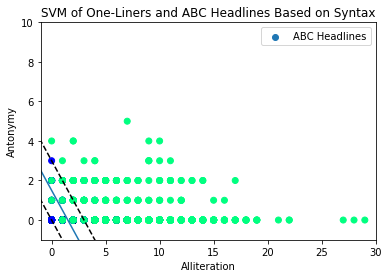

In [18]:
# Syntax SVM Graph
# Deconstruct Syntax SVM to plot oneliners/abc news classification boundary

oneliners_sample, abc_news_sample = len_match(oneliners, abc_news)
df_sample = df_arrange(oneliners_sample, abc_news_sample)

training_set, test_set = train_test_split(df_sample, test_size = 0.2, random_state = 1)
x_train = training_set.iloc[:,0:2].values
y_train = training_set.iloc[:,2].values
x_test = test_set.iloc[:,0:2].values
y_test = test_set.iloc[:,2].values

classifier = SVC(kernel='linear', random_state = 1, gamma= 'auto')
classifier.fit(x_train,y_train)
y_pred = list(classifier.predict(x_test))
test_set["Predictions"] = y_pred

y_num = []
for word in y_train:
    if word == "humor":
        y_num.append(1)
    else:
        y_num.append(-1)

# Plot Syntax SVM - since alliteration and antonymy are the inputs, plot is 2-dimensional
# input data
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_num, cmap='winter')
plt.xlim = (0,30)
plt.ylim = (0,10)
plt.title("SVM of One-Liners and ABC Headlines Based on Syntax")
plt.xlabel("Alliteration")
plt.ylabel("Antonymy")
plt.legend(["ABC Headlines", "One-Liners"])

# classification boundary
ax = plt.gca()
xlim = ax.get_xlim()
w = classifier.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - classifier.intercept_[0] / w[1]
plt.plot(xx, yy)
plt.xlim = (0,30)
plt.ylim = (0,10)
yy = a * xx - (classifier.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
plt.xlim = (0,30)
plt.ylim = (0,10)
yy = a * xx - (classifier.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')
ax.set_xlim([-1,30])
ax.set_ylim([-1,10])
plt.savefig("Figures/syntax_svm.png")

# Syntax and Content SVM

In [22]:
## CONTENT MODEL
# import word processing packages
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

In [23]:
def corpus_arrange(humor, nonhumor):
   
    # create list of phrases 
    phrase = []
    for i in range(len(humor)):
        phrase.append(humor[i][0])
    for i in range(len(nonhumor)):
        phrase.append(nonhumor[i][0])
       
    # create list of humor and non-humor labels
    label = []
    for i in range(len(humor)):
        label.append("humor")
    for i in range(len(nonhumor)):
        label.append("nonhumor")
        
    # create data frame
    column_names = ["text", "label"]
    corpus = pd.DataFrame(columns = column_names)
    corpus['text'] = phrase
    corpus['label'] = label
    
    # process and prepare text for SVM input
    corpus['text'].dropna(inplace=True)
    corpus['text'] = [entry.lower() for entry in corpus['text']]
    corpus['text'] = [word_tokenize(entry) for entry in corpus['text']]
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    for index, entry in enumerate(corpus['text']):
        final_words = []
        word_lemmatized = WordNetLemmatizer()
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word.isalpha():
                word_final = word_lemmatized.lemmatize(word,tag_map[tag[0]])
                final_words.append(word_final)
        corpus.loc[index,'text_final'] = str(final_words)
    return corpus

def content_svm(corpus):
    # fit a SVM based on content and syntax
    x_train, x_test, y_train, y_test = model_selection.train_test_split(corpus['text_final'],corpus['label'],test_size=0.2)
    
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(corpus['text_final'])
    x_train_Tfidf = Tfidf_vect.transform(x_train)
    x_test_Tfidf = Tfidf_vect.transform(x_test)

    # fit SVM
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(x_train_Tfidf, y_train)
    
    # predict
    predictions_SVM = SVM.predict(x_test_Tfidf)
    accuracy = accuracy_score(predictions_SVM, y_test)

    return accuracy
    
def content_svm_model(humor, nonhumor):
    # run full content SVM model
    humor, nonhumor = len_match(humor, nonhumor)
    corpus = corpus_arrange(humor, nonhumor)
    accuracy = content_svm(corpus)
    return accuracy

In [24]:
# run syntax SVM on humor/nonhumor data set pairings
np.random.seed(403)
content_svm_model_acc = [content_svm_model(oneliners, abc_news), content_svm_model(oneliners, proverbs),
                        content_svm_model(nycc, abc_news), content_svm_model(nycc, proverbs)]

# Context SVM

In [21]:
def context_arrange(humor, nonhumor, context):
    
    # create dictionaries with alliteration per phrase
    humor_all_dict = alliteration_dict(humor)
    nonhumor_all_dict = alliteration_dict(nonhumor)
    # create dictionaries with antonyms per phrase
    humor_ant_dict = antonym_dict(humor)
    nonhumor_ant_dict = antonym_dict(nonhumor)
    # create dictionaries with synonyms per phrase
    humor_syn_dict = synonym_dict(humor, list(context[-1][1:]))
    nonhumor_syn_dict = synonym_dict(nonhumor, list(context[-1][1:]))
    
    # create list of phrases
    phrase = []
    for i in range(len(humor)):
        phrase.append(humor[i][0])
    for i in range(len(nonhumor)):
        phrase.append(nonhumor[i][0])
    
    # create list of labels
    label = []
    for i in range(len(humor)):
        label.append("humor")
    for i in range(len(nonhumor)):
        label.append("nonhumor")
    
    # create list of alliteration values
    alit_lst = []
    for i in range(len(humor)):
        alit_lst.append(list(humor_all_dict.values())[i])
    for i in range(len(nonhumor)):
        alit_lst.append(list(nonhumor_all_dict.values())[i])
    
    # create list of antonym values
    ant_lst = []
    for i in range(len(humor)):
        ant_lst.append(list(humor_ant_dict.values())[i])
    for i in range(len(nonhumor)):
        ant_lst.append(list(nonhumor_ant_dict.values())[i])
        
    # create list of synonym values
    syn_lst = []
    for i in range(len(humor)):
        syn_lst.append(list(humor_syn_dict.values())[i])
    for i in range(len(nonhumor)):
        syn_lst.append(list(nonhumor_syn_dict.values())[i])
    
    # create data frame
    column_names = ["phrase", "alliteration", "antonymy", "synonym", "label"]
    corpus = pd.DataFrame(columns = column_names)
    corpus['text'] = phrase
    corpus['alliteration'] = alit_lst
    corpus['antonymy'] = ant_lst
    corpus['synonym'] = syn_lst
    corpus['label'] = label
    
    corpus['text'].dropna(inplace=True)
    corpus['text'] = [entry.lower() for entry in corpus['text']]
    
    corpus['text'] = [word_tokenize(entry) for entry in corpus['text']]
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    
    for index, entry in enumerate(corpus['text']):
        final_words = []
        word_lemmatized = WordNetLemmatizer()
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word.isalpha():
                word_final = word_lemmatized.lemmatize(word,tag_map[tag[0]])
                final_words.append(word_final)
        corpus.loc[index,'text_final'] = str(final_words)

    return corpus

def context_svm(corpus):
    
    training_set, test_set = train_test_split(corpus, test_size = 0.3, random_state = 1)
    X_train = training_set.iloc[:,1:5].values
    Y_train = training_set.iloc[:,5].values
    X_test = test_set.iloc[:,1:5].values
    Y_test = test_set.iloc[:,5].values
    
    Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(corpus['text_final'],corpus['label'],test_size=0.3)
    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(Train_Y)
    Test_Y = Encoder.fit_transform(Test_Y)

    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(corpus['text_final'])
    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)

    # fit SVM
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(Train_X_Tfidf,Train_Y)
    # predict
    predictions_SVM = SVM.predict(Test_X_Tfidf)
    accuracy = accuracy_score(predictions_SVM, Test_Y)
    
    return accuracy

def context_svm_model(humor, nonhumor, context):
    humor, nonhumor = len_match(humor, nonhumor)
    corpus = context_arrange(humor, nonhumor, context)
    accuracy = context_svm(corpus)
    return accuracy

In [22]:
# run context SVM on humor/nonhumor data set pairings
np.random.seed(403)
context_svm_model_acc = [context_svm_model(nycc_context, abc_news, context),
                         context_svm_model(nycc_context, proverbs, context)]

# Analysis

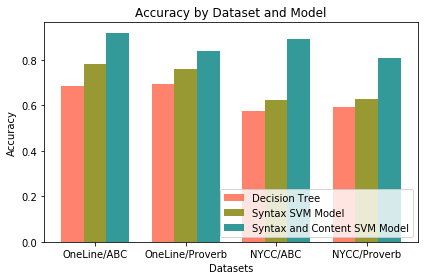

In [23]:
# Show improvements in accuracy across models
n_groups = 4

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

tree_acc = plt.bar(index, tree_model_acc, bar_width,
alpha=opacity,
color='tomato',
label='Decision Tree')

syntax_acc = plt.bar(index + bar_width, syntax_svm_model_acc, bar_width,
alpha=opacity,
color='olive',
label='Syntax SVM Model')

content_acc = plt.bar(index + 2*bar_width, content_svm_model_acc, bar_width,
alpha=opacity,
color='teal',
label='Syntax and Content SVM Model')

plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('Accuracy by Dataset and Model')
plt.xticks(index + bar_width, ('OneLine/ABC', 'OneLine/Proverb',
                               'NYCC/ABC', 'NYCC/Proverb'))
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('Figures/model_comparison.png')
plt.show()



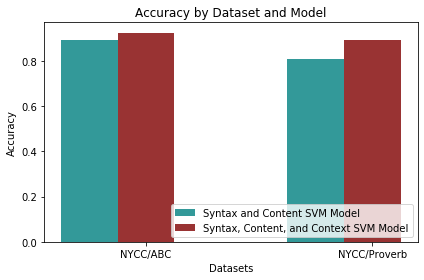

In [24]:
# show improvement for context-dependent data
n_groups = 2
labels = ['NYCC/ABC', 'NYCC/Proverb']

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = .8

content_acc = plt.bar(index, content_svm_model_acc[2:4], bar_width,
alpha=opacity,
color='teal',
label='Syntax and Content SVM Model')

context_acc = plt.bar(index + bar_width, context_svm_model_acc, bar_width,
alpha = opacity,
color = 'maroon',
label='Syntax, Content, and Context SVM Model')

plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('Accuracy by Dataset and Model')
plt.xticks(index + bar_width, labels)
plt.ylim = (0,2)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('Figures/context_comparison.png')
plt.show()